# **\[Essays\]** 루나랜더 v2 (간략화)

신록예찬  
2023-08-16

# imports

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

# 기존알고리즘

In [2]:
class Agent():
    def __init__(self,env):
        self.buffer_size = 10000 
        self.batch_size = 128
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.eps = 0
        self.n_experiences = 0
        self.n_epoch = 0
        self.scores = [] 
        self.playtimes = []

        # Q-Network
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.state_size,128), 
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,self.action_size)) 
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        # ReplayBuffer
        self.memory = collections.deque(maxlen=self.buffer_size)
        self.current_states = collections.deque(maxlen=self.buffer_size)
        self.actions = collections.deque(maxlen=self.buffer_size)
        self.rewards = collections.deque(maxlen=self.buffer_size)
        self.next_states = collections.deque(maxlen=self.buffer_size)
        self.terminations = collections.deque(maxlen=self.buffer_size)

    # agent >> env 
    def __rshift__(self,env):
        if np.random.rand() > self.eps:
            self.action = self.net(torch.tensor(self.current_state)).argmax().item()
        else:
            self.action = random.choice(np.arange(self.action_size))
        env.received_action = self.action 

    # agent << env 
    def __lshift__(self,env): 
        self.next_state, self.reward, self.terminated, _, _ = env.step(env.received_action)
        
    def save_experience(self):
        """Add a new experience to memory."""
        self.current_states.append(self.current_state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated) 
        self.n_experiences = len(self.current_states)
    
    def get_batch(self):
        idx = np.random.randint(0,self.n_experiences,size=self.batch_size) 
        self.current_states_batch = torch.tensor(np.array(self.current_states)[idx],dtype=torch.float32)
        self.actions_batch = torch.tensor(np.array(self.actions)[idx],dtype=torch.int64).reshape(self.batch_size,1) 
        self.rewards_batch = torch.tensor(np.array(self.rewards)[idx],dtype=torch.float32).reshape(self.batch_size,-1) 
        self.next_states_batch = torch.tensor(np.array(self.next_states)[idx],dtype=torch.float32)
        self.terminations_batch = torch.tensor(np.array(self.terminations)[idx],dtype=torch.int64).reshape(self.batch_size,-1) 

    def learn(self):
        if self.n_experiences < self.batch_size:
            pass
        else: 
            self.get_batch()
            
            q_targets_next = self.net(self.next_states_batch).detach().max(1)[0].unsqueeze(1)
            q_targets = self.rewards_batch + 0.99 * q_targets_next * (1 - self.terminations_batch)
            q_expected = self.net(self.current_states_batch).gather(1, self.actions_batch)
            
            loss = torch.nn.functional.mse_loss(q_expected, q_targets)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    # agent**env: reset 
    def __pow__(self,env): 
        self.current_state, _ = env.reset()
        self.terminated = False
        self.score = 0 

In [24]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [25]:
agent = Agent(env)

In [26]:
n_episodes = 2000
max_t = 500
agent.eps = 1.0 
for e in range(2000):
    agent ** env 
    for t in range(500):
        agent >> env 
        agent << env 
        agent.save_experience()
        agent.learn()
        agent.current_state = agent.next_state 
        agent.score += agent.reward
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.eps = agent.eps * 0.995 
    print('\rEpisode {}\tAverage Score: {:.2f}\t'.format(e, np.mean(agent.scores[-100:])), end="")
    if e % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(agent.scores[-100:])))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
    if np.mean(agent.scores[-100:])>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(agent.scores[-100:])))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
        break

Episode 0   Average Score: -65.15   
Episode 100 Average Score: -122.77  
Episode 200 Average Score: -25.46       
Episode 300 Average Score: 88.00        
Episode 400 Average Score: 185.96   
Episode 414 Average Score: 200.84   
Environment solved in 414 episodes! Average Score: 200.84

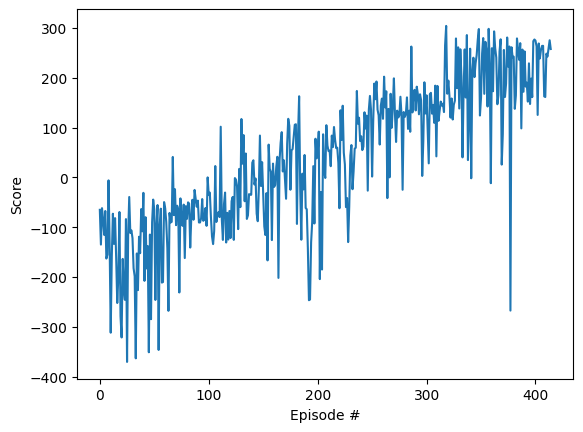

In [27]:
plt.plot(agent.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

In [28]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')
agent = Agent(env)
agent ** env
agent.net.load_state_dict(torch.load('checkpoint.pth'))
agent.terminated = False
figs = [] 

while not agent.terminated:
    figs.append(env.render())
    agent >> env 
    agent << env 
    agent.current_state = agent.next_state 
env.close()

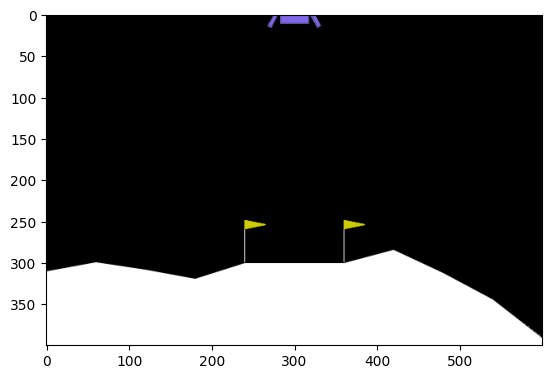

In [29]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(figs[::10][i]),frames=len(figs[::10]))

`-` 방법1

In [30]:
#ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [31]:
IPython.display.HTML(ani.to_jshtml())